In [77]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 
from matplotlib import pyplot as plt
import time 
import copy 

import sys 
sys.path.append('../src/')

from src.models.GSNN import GSNN
from src.data.LincsDataset import LincsDataset
from src.models.SparseLinear import SparseLinear
from src.models.SparseLinear2 import SparseLinear2
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
B = 100
M = 100
N = 400
E = int(0.5*M*N)

x = torch.randn((B, N, 1))
indices = torch.stack((torch.randint(0, N, size=(E,)), torch.randint(0, M, size=(E,))), dim=0)
size = (N,M)

lin = SparseLinear(indices, size, d=None, dtype=torch.float32)
lin2 = SparseLinear2(indices, size, d=None, dtype=torch.float32)

lin2.values = copy.deepcopy(lin.values)

out = lin(x)
out2 = lin2(x)

torch.isclose(out, out2, 1e-2).all()

tensor(True)

In [71]:
print(out.view(-1)[:5])
print(out2.view(-1)[:5])
print(torch.isclose(out2.view(-1)[:5], out.view(-1)[:5]))

tensor([ 14.1868,  23.5823, -12.6891,   6.5630,  13.2292],
       grad_fn=<SliceBackward0>)
tensor([ 14.1868,  23.5823, -12.6891,   6.5630,  13.2292],
       grad_fn=<SliceBackward0>)
tensor([True, True, True, True, True])


In [79]:
# check grad is the same as well 
out.mean().backward()
out2.mean().backward()

torch.isclose(lin.values.grad, lin2.values.grad).all()

In [73]:
repeats=50

times = []
for i in range(repeats): 
    tic = time.time() 
    out = lin(x)
    times.append(time.time() - tic)

times2 = []
for i in range(repeats): 
    tic = time.time() 
    out = lin2(x)
    times2.append(time.time() - tic)

print('SparseLinear', np.mean(times))
print('SparseLinear2', np.mean(times2))
print('Factor of improvement:', np.mean(times)/np.mean(times2))

SparseLinear 0.051691644191741944
SparseLinear2 0.04347049713134766
Factor of improvement: 1.1891201528143052


In [76]:
x = x.to('cuda')
lin = lin.to('cuda')
lin2 = lin2.to('cuda')

repeats=100

times = []
for i in range(repeats): 
    tic = time.time() 
    out = lin(x)
    times.append(time.time() - tic)

times2 = []
for i in range(repeats): 
    tic = time.time() 
    out = lin2(x)
    times2.append(time.time() - tic)

print('SparseLinear', np.mean(times))
print('SparseLinear2', np.mean(times2))
print('Factor of improvement:', np.mean(times)/np.mean(times2))

SparseLinear 0.15959790706634522
SparseLinear2 0.00682046890258789
Factor of improvement: 23.39984381510617


In [62]:
W = torch.sparse_coo_tensor(indices=indices, values=torch.randn((indices.size(1))), size=(N,M))

In [63]:
W.size()

torch.Size([400, 100])

In [65]:
W.unsqueeze(0).size()

torch.Size([1, 400, 100])

In [67]:
torch.stack([W for i in range(B)], dim=0)

tensor(indices=tensor([[  0,   0,   0,  ...,  99,  99,  99],
                       [178, 191, 273,  ..., 306, 254,  57],
                       [ 53,  97,  20,  ...,  99,  39,  61]]),
       values=tensor([ 1.0166,  0.5111, -0.7829,  ...,  0.6958, -0.4958,
                       1.9568]),
       size=(100, 400, 100), nnz=2000000, layout=torch.sparse_coo)

In [2]:
# edge id -->               0  1  2  3  4  5  6
edge_index = torch.tensor([[0, 0, 1, 2, 3, 2, 2, 3],
                           [1, 2, 3, 1, 1, 3, 4, 5]], dtype=torch.long)

E = edge_index.size(1)
N = torch.unique(edge_index.view(-1)).size(0)

# only node 0 is input node 
input_node_mask = torch.tensor([True, False, False, False, False, False])
assert input_node_mask.size(0) == N, '`input_node_mask` should have N elements. '

# nodes 4,5 are output nodes 
output_node_mask = torch.tensor([False, False, False, False, True, True])
assert input_node_mask.size(0) == N, '`output_node_mask` should have N elements. '

# shape (B, N, 1)
# NOTE: represents NODE inputs 
x =  torch.tensor([[1., 0., 0., 0.,0.,0.],
                    [-1., 0., 0., 0.,0.,0.]]).unsqueeze(-1)


B = x.size(0)
N = torch.unique(edge_index).view(-1).size(0)

# NOTE: node attrs are now handled by additional input nodes. 

print('# Nodes (N)', N)
print('# Edges (E)', E)

# Nodes (N) 6
# Edges (E) 8


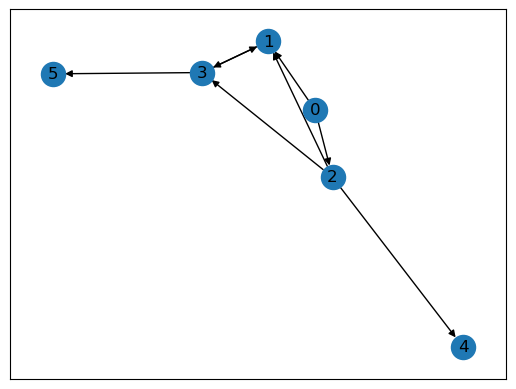

In [3]:
E = (E.detach().cpu().numpy().tolist() for E in edge_index.T)
G = nx.DiGraph(E)

nx.draw_networkx(G)

In [4]:
model = GSNN(edge_index, channels=2, input_node_mask=input_node_mask, output_node_mask=output_node_mask, layers=10)#.to('cuda')

In [5]:
tic = time.time()
out = model(x.cpu())
e1 = time.time() - tic 

loss = (out**2).mean()
loss.backward() 
print('grad', model.lin1.values.grad)
print(out)
print(e1)

looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
looping!a adfadsf 
grad tensor([ 1.0820e-21,  3.0507e-19,  1.0606e-09, -2.0782e-10,  9.3967e-10,
         1.0693e-12,  1.1211e-22,  3.1609e-20, -4.8310e-22, -1.3621e-19,
        -7.9837e-10, -9.6953e-13,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000, -0.3265, -3.4566],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.5165,  1.5698]],
       grad_fn=<CopySlices>)
0.008595466613769531


In [30]:
tic = time.time()
out = model(x.cpu())
e1 = time.time() - tic 

loss = (out**2).mean()
loss.backward() 
print('grad', model.lin1.values.grad)
print(out)
print(e1)

extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
extending!
grad tensor([ 7.6634e-14,  1.6163e-14,  2.5726e-09,  1.8959e-09, -3.2965e-05,
         1.3093e-06,  5.9382e-16,  1.2524e-16, -8.0841e-14, -1.7050e-14,
         7.8669e-05, -3.1246e-06,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00])
tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.8634,  2.1527],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.3370, -1.3892]],
       grad_fn=<CopySlices>)
0.008127927780151367


In [20]:
model(x.cpu())

looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!
looping!


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.8634,  2.1527],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -1.3370, -1.3892]],
       grad_fn=<CopySlices>)

In [209]:
optim = torch.optim.Adam(model.parameters())

In [210]:
x = x.to('cuda')

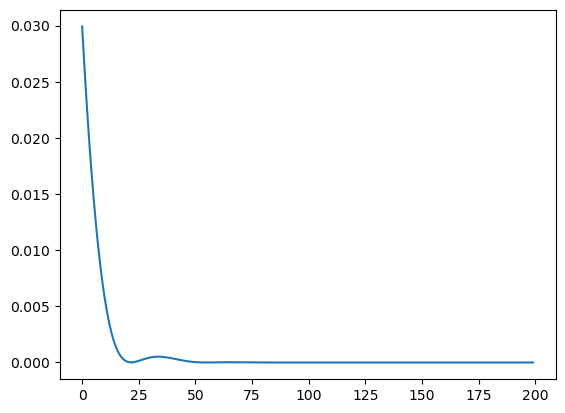

In [211]:
losses = []
for i in range(200): 
    optim.zero_grad()
    out = model(x)
    loss = (out**2).mean() 
    loss.backward()
    optim.step()
    losses.append(loss.item())

plt.figure()
plt.plot(losses)
plt.show()

In [204]:
optim.zero_grad()
out = model(x)
loss = out.mean() 
loss.backward()

In [197]:
model.lin3.values.grad

tensor([-0.1640, -0.2685,  0.0016,  0.0059,  0.0146,  0.0025,  0.0073,  0.0181,
         0.0016,  0.0056, -0.0007,  0.0007])